### Add Path to Import Libraires from Parent Directory

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import chess

# Possible Moves

### AlphaZero’s Specific Choice

In the AlphaZero paper (“Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm,” 2017), the action space is described as:

- Moves are represented as 73 planes (for move types) × 64 squares (for source positions).
- The 73 planes break down as:
    - 56 queen-move planes: 8 directions × 7 distances.
    - 8 knight-move planes: 8 possible knight moves.
    - 9 promotion planes: 3 move types (straight, capture left, capture right) × 3 underpromotions (rook, bishop, knight; queen promotion is implicit or --handled separately).
- Total actions:
```64 squares × 73 move types = 4672```

This encoding ensures every legal move (including promotions, castling, and en passant) can be mapped to one of the 4672 indices, with illegal or redundant indices masked during training and inference.

### Each players have 16 pieces on the board
> Rook -  ```2 pieces x 4 directions x 7 distances = 2 x 28 actions```\
> Knight - ```2 pieces x 8 directions = 2 x 8 actions```\
> Bishop - ```2 pieces x 4 directions x 7 distances = 2 x 28 actions```\
> Queen - ```1 piece x 8 directions x 7 distances = 1 x 56 actions```\
> King - ```1 piece x (8 directions + 2 Types of Castlings) = 1 x 10 actions```\
> Pawn - ```8 pieces x (2 forward moves + 2 capture moves + 2 En Passant + 12 promotion moves (Fwd/CapL/CapR for Q, N, B, R) + Queen's 56 actions + Knight's 8 actions) = 8 x 82 actions```\
(Having potential to gain Rook, Bishop, Queen or Knight's move)

> Total possible actions per player: ```2x28 + 2x8 + 2x28 + 1x56 + 1x10 + 8x82 = 56 + 16 + 56 + 56 + 10 + 656 = 850 actions```

- However, this is the theoretical maximum. In practice, many moves are blocked by other pieces or would put the king in check.

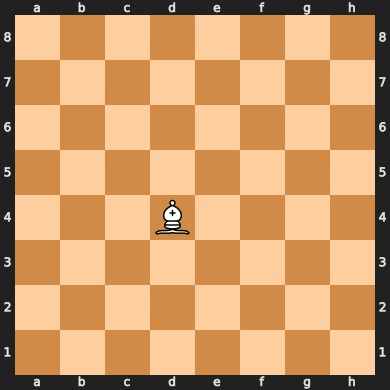

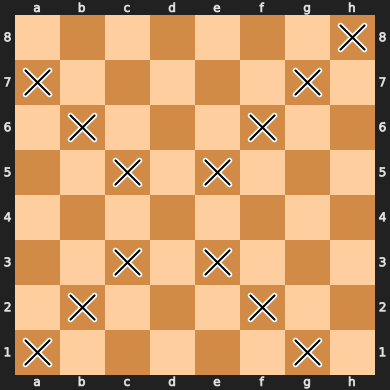

In [2]:
from chess import *
from IPython.display import display

# ROOK, BISHOP, KNIGHT, QUEEN, KING, PAWN
piece = Piece(BISHOP, WHITE)

board = Board()
board.clear()
board.set_piece_at(D4, piece)

sqaureset = SquareSet(map(lambda x: x.to_square, board.legal_moves))
display(board, sqaureset)

### Visualize All Actions on the Board with Local Action ID

In [3]:
import chess
from typing import List, Dict, Optional
from collections import defaultdict

from utils.analyze import (
    uci_to_relative_rook_action_id,
    uci_to_relative_knight_action_id,
    uci_to_relative_bishop_action_id,
    uci_to_relative_queen_action_id,
    uci_to_relative_king_action_id,
    uci_to_relative_pawn_action_id,
)
from utils.visualize import draw_numbers_on_board, display_svgs_horizontally


def get_relative_action_id_for_piece(uci: str, piece_type: chess.PieceType, color: chess.Color) -> Optional[int]:
    """
    Helper function to call the correct uci_to_relative_*_action_id function.
    Returns the RELATIVE action ID (e.g., 1-28 for Rook, 1-18 for Pawn).
    """
    if piece_type == chess.ROOK:
        return uci_to_relative_rook_action_id(uci)
    elif piece_type == chess.KNIGHT:
        return uci_to_relative_knight_action_id(uci)
    elif piece_type == chess.BISHOP:
        return uci_to_relative_bishop_action_id(uci)
    elif piece_type == chess.QUEEN:
        return uci_to_relative_queen_action_id(uci)
    elif piece_type == chess.KING:
        # Castling (IDs 9, 10) and standard moves (1-8) are handled within this func
        return uci_to_relative_king_action_id(uci)
    elif piece_type == chess.PAWN:
        # Pass the color required by the updated pawn function
        return uci_to_relative_pawn_action_id(uci, color)
    else:
        print(f"Warning: Unknown piece type {piece_type} in get_relative_action_id_for_piece")
        return None

def get_relative_action_ids_for_target_type(
    board: chess.Board,
    target_piece_type: chess.PieceType
) -> Dict[chess.Square, List[str]]:
    """
    Generates a map from destination squares to a list of RELATIVE action ID strings
    for legal moves of a specific piece type on the board.

    Args:
        board: The current chess.Board state.
        target_piece_type: The chess.PieceType to filter moves for (e.g., chess.PAWN).

    Returns:
        A dictionary mapping the destination square (chess.Square) of each valid move
        by the target piece type to a list of its calculated relative action ID strings
        (e.g., ['1'] for pawn e2e4, ['1', '8'] for knight g1 moves).
    """
    dest_square_to_action_ids: Dict[chess.Square, List[int]] = defaultdict(list)
    final_map: Dict[chess.Square, List[str]] = {}
    # No instance map needed for relative IDs based purely on move pattern

    for move in board.legal_moves:
        # Determine the type and color of the piece being moved
        piece_at_from_sq = board.piece_at(move.from_square)

        if piece_at_from_sq and piece_at_from_sq.piece_type == target_piece_type:
            # Get the RELATIVE action ID using the helper function
            # Pass the color needed for pawn relative ID calculation
            relative_id = get_relative_action_id_for_piece(
                move.uci(),
                piece_at_from_sq.piece_type,
                piece_at_from_sq.color
            )

            if relative_id is not None:
                # Append the integer relative action ID to the list for the destination square
                dest_square_to_action_ids[move.to_square].append(relative_id)
            # else: (Optional: Add warning if relative_id is None for a legal move)
                 # print(f"Warning: Could not get RELATIVE action ID for legal move {move.uci()} "
                 #       f"for target type {target_piece_type}")


    # Convert lists of integers to lists of strings
    for square, id_list in dest_square_to_action_ids.items():
        final_map[square] = [str(action_id) for action_id in sorted(id_list)]

    return final_map

In [4]:
import chess
board = chess.Board()

board.clear()
board.set_piece_at(chess.A1, chess.Piece(chess.QUEEN, chess.WHITE))
svg1 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.QUEEN), board, board_size=300, font_size=32)

board.clear()
board.set_piece_at(chess.D8, chess.Piece(chess.QUEEN, chess.WHITE))
svg2 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.QUEEN), board, board_size=300, font_size=32)

board.clear()
board.set_piece_at(chess.D4, chess.Piece(chess.QUEEN, chess.WHITE))
svg3 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.QUEEN), board, board_size=300, font_size=32)

display_svgs_horizontally([svg1, svg2, svg3])

In [5]:
board = chess.Board()

board.clear()
board.set_piece_at(chess.G1, chess.Piece(chess.KNIGHT, chess.WHITE))
svg1 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.KNIGHT), board, board_size=300, font_size=32)

board.clear()
board.set_piece_at(chess.B8, chess.Piece(chess.KNIGHT, chess.WHITE))
svg2 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.KNIGHT), board, board_size=300, font_size=32)

board.clear()
board.set_piece_at(chess.D4, chess.Piece(chess.KNIGHT, chess.WHITE))
svg3 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.KNIGHT), board, board_size=300, font_size=32)

display_svgs_horizontally([svg1, svg2, svg3])

In [6]:
board = chess.Board()

board.clear()
board.set_piece_at(chess.C7, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.B8, chess.Piece(chess.PAWN, chess.BLACK))
board.set_piece_at(chess.D8, chess.Piece(chess.PAWN, chess.BLACK))
svg1 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.PAWN), board, board_size=300, font_size=32)

board.clear()
board.set_piece_at(chess.C6, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.B7, chess.Piece(chess.PAWN, chess.BLACK))
svg2 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.PAWN), board, board_size=300, font_size=32)

board.clear()
board.set_piece_at(chess.C2, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.D3, chess.Piece(chess.PAWN, chess.BLACK))
svg3 = draw_numbers_on_board(get_relative_action_ids_for_target_type(board, chess.PAWN), board, board_size=300, font_size=32)

display_svgs_horizontally([svg1, svg2, svg3])

### Test

In [7]:
import chess_gym
import gymnasium as gym
from utils.visualize import draw_possible_actions_on_board, display_svgs_horizontally

env = gym.make("Chess-v0")
env.reset()
board = env.action_space.board

# check all action ids
for i in range(1, 1700):
    move = board.action_id_to_move(i)
    if move:
        print(f"{i}: {move.uci()}")

svg1 = draw_possible_actions_on_board(board)
svg2 = draw_possible_actions_on_board(board, draw_action_ids=True)
display_svgs_horizontally([svg1, svg2])
env.step(env.action_space.sample(return_id=True))
svg1 = draw_possible_actions_on_board(board)
svg2 = draw_possible_actions_on_board(board, draw_action_ids=True)
display_svgs_horizontally([svg1, svg2])


57: b1c3
64: b1a3
65: g1h3
72: g1f3
195: a2a3
196: a2a4
277: b2b3
278: b2b4
359: c2c3
360: c2c4
441: d2d3
442: d2d4
523: e2e3
524: e2e4
605: f2f3
606: f2f4
687: g2g3
688: g2g4
769: h2h3
770: h2h4


/Users/minseo/Documents/Github/_star14ms/Chess_AI/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


/Users/minseo/Documents/Github/_star14ms/Chess_AI/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [8]:
from chess import BLACK, WHITE
from utils.visualize import draw_possible_actions_on_board, display_svgs_horizontally

options = {
    'fen': "7k/8/8/8/8/8/p7/7K w KQkq - 0 1",
    # 'fen': "r3k2r/8/8/8/8/8/7p/4K3 w KQkq - 0 1",
    'turn': BLACK,
}
env.reset(options=options)
board = env.action_space.board
svg_possible_a1s = draw_possible_actions_on_board(board)

action = env.action_space.sample()
env.step(action)
svg_a1 = board._repr_svg_()
svg_possible_a2s = draw_possible_actions_on_board(board)

display_svgs_horizontally([svg_possible_a1s, svg_a1, svg_possible_a2s])

action = env.action_space.sample()
env.step(action)
svg_a2 = board._repr_svg_()
svg_possible_a3s = draw_possible_actions_on_board(board)

display_svgs_horizontally([svg_a1, svg_a2, svg_possible_a3s])